## The goal of Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv('geocoded.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614 entries, 0 to 7613
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    7614 non-null   int64  
 1   bed             7614 non-null   float64
 2   bath            7614 non-null   float64
 3   acre_lot        7614 non-null   float64
 4   zip_code        7614 non-null   float64
 5   house_size      7614 non-null   float64
 6   prev_sold_date  7614 non-null   object 
 7   price           7614 non-null   float64
 8   prev_sold_year  7614 non-null   int64  
 9   zip_code_str    7614 non-null   int64  
 10  latitude        7614 non-null   float64
 11  longitude       7614 non-null   float64
 12  county          7614 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 773.4+ KB


#### Create an object to pass to the function that will normalize the data

In [4]:
params = {
    "data":outliers_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,zip_code,latitude,longitude
7609,1.488841,1.569459,0.024249,-0.289298,-0.122074,2017,8848.0,40.594266,-75.096659
7610,0.594761,0.570390,0.157168,-0.289298,-0.060054,2016,8825.0,40.514169,-75.027112
7611,-0.299318,-0.428678,-0.059088,-0.289298,-0.087343,2021,7012.0,40.848398,-74.160266
7612,-0.299318,0.570390,-0.058033,-0.289298,-0.010439,2022,7012.0,40.848398,-74.160266
7613,0.594761,0.570390,-0.060143,-0.289298,0.460910,2016,7640.0,40.991681,-73.980202


#### Create a variable for the correlation of the normalized data

In [5]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.037860
bed               0.413451
bath              0.584847
house_size        0.337901
prev_sold_year    0.039367
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

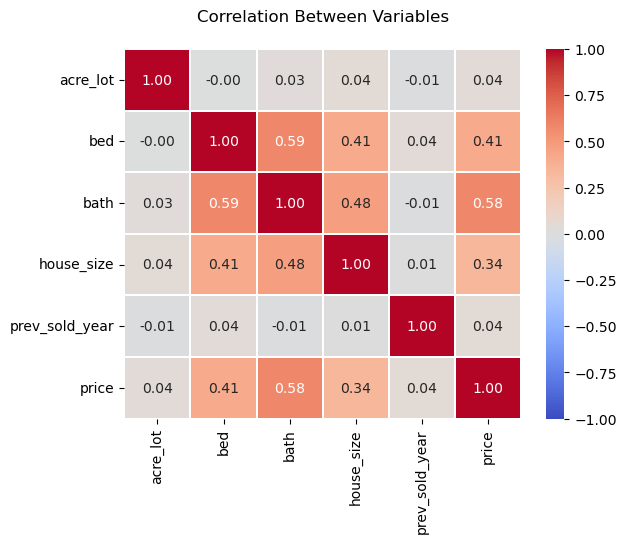

In [6]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [7]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


#### Create a variable to be used to PairPlot the features that correlate with the price feature

In [8]:
pariplot_features = []
for feature, value in correlation["price"].items():
        pariplot_features.append(feature)

#### The PairPlot diagram might take too long so it's a good idea to comment it out

In [9]:
# sns.pairplot(normalize_df[pariplot_features])

#### Create common variables to store frequently used values.

In [10]:
#features = ["latitude","longitude","bed","bath","house_size"]
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [11]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [12]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [13]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [14]:
params = {'max_depth': range(5,15,1),
         'random_state':[42]}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=params).fit(X_train, y_train)
grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_
best_params

{'max_depth': 10, 'random_state': 42}

#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [15]:
dtree = dosomething("Decision Tree","Decision Tree Best Params", normalize_df, features, "price", best_params)
results_dict_append(dtree["results"])
dtree_bp_predict = dtree["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Decision Tree Best Params EVS = 0.510980541
Decision Tree Best Params MSE = 0.485324
Decision Tree Best Params MAE = 0.399318
Decision Tree Best Params R2 = 0.509984
Decision Tree Best Params Fit Time = 0.012153387069702148


#### cost_complexity_pruning_path

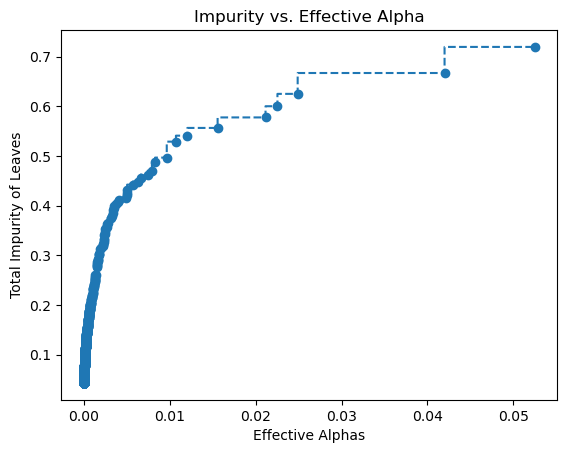

In [16]:
path = DecisionTreeRegressor().cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.step(ccp_alphas[:-1], impurities[:-1], '--o')
plt.title('Impurity vs. Effective Alpha')
plt.xlabel('Effective Alphas')
plt.ylabel('Total Impurity of Leaves');

### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [17]:
dtree_rfe = dosomething("Decision Tree","Recursive Feature Elimination", normalize_df, features, "price")
results_dict_append(dtree_rfe["results"])
dtree_rfe_predict = dtree_rfe["predictions"]

The selected features are: ['latitude', 'longitude', 'bath', 'house_size']
Recursive Feature Elimination EVS = 0.516497200
Recursive Feature Elimination MSE = 0.480858
Recursive Feature Elimination MAE = 0.406252
Recursive Feature Elimination R2 = 0.514494
Recursive Feature Elimination Fit Time = 0.024599170684814452


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator. 

In [18]:
dtree_sfs = dosomething("Decision Tree","Sequential Feature Selector", normalize_df, features, "price")
results_dict_append(dtree_sfs["results"])
dtree_sfs_predict = dtree_sfs["predictions"]

The selected features are: ['latitude', 'bed', 'bath', 'house_size']
Sequential Feature Selector EVS = 0.356544114
Sequential Feature Selector MSE = 0.640597
Sequential Feature Selector MAE = 0.456555
Sequential Feature Selector R2 = 0.353210
Sequential Feature Selector Fit Time = 0.015623044967651368


#### Graphing the results works best when the data is provided in a DataFrame.

In [19]:
dtree_bp_predict_df = pd.DataFrame(dtree_bp_predict).reset_index()
dtree_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### The predictions provided by the best parameters have the appearance of banding.  I will conduct more testing to determine if this is acceptable or if this is a case of underfitting or overfitting.

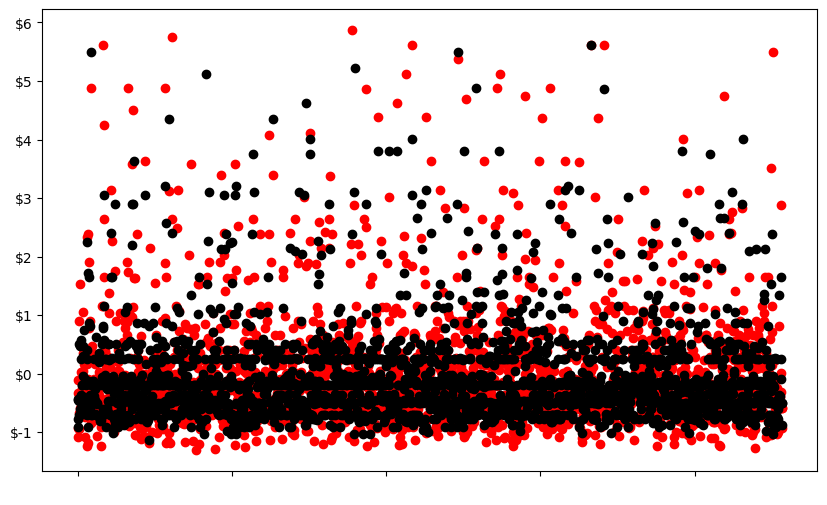

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

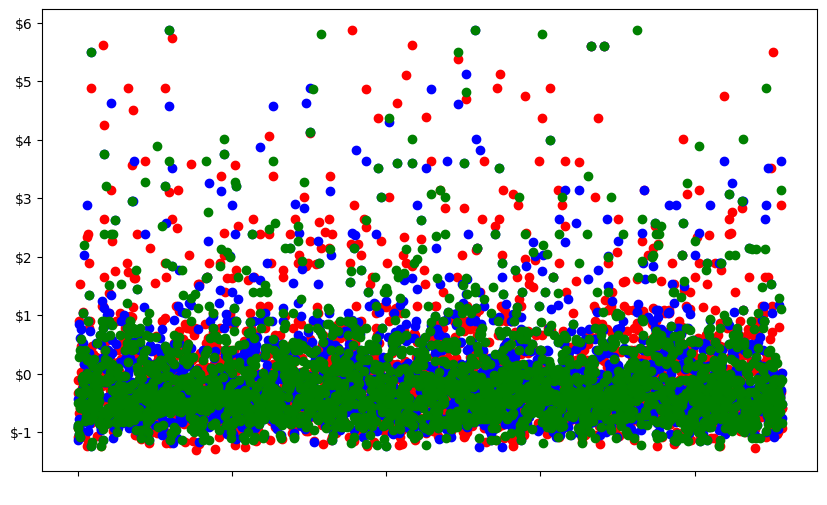

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [22]:
results_dict

{'model': ['Decision Tree Best Params',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.510980541', '0.516497200', '0.356544114'],
 'mae score': ['0.399318', '0.406252', '0.456555'],
 'mse score': ['0.485324', '0.480858', '0.640597'],
 'r2 score': ['0.509984', '0.514494', '0.353210'],
 'mean fit time': [0.012153387069702148,
  0.024599170684814452,
  0.015623044967651368]}

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Decision Tree Best Params,0.510980541,0.399318,0.485324,0.509984,0.012153
Recursive Feature Elimination,0.516497200,0.406252,0.480858,0.514494,0.024599
Sequential Feature Selector,0.356544114,0.456555,0.640597,0.353210,0.015623
